In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
import scipy.io as sio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fftfreq
from numpy.fft import fft, ifft
from scipy import fftpack
import scipy.signal as sig
import warnings

# here change path according to your drive
mat_contents = sio.loadmat('path/Spindles_All_StartEndTimes_1SD.mat')
LFP_spindle = sio.loadmat('path/PFC_LFP_filtered_Spindle.mat')
timestamp = sio.loadmat('path/LFP_Timestamp.mat')

spindleStartEnd = mat_contents['AllSpindlesStartEnd']
LFP_spindle = LFP_spindle['FilteredLFP_6_14']
T = timestamp['tsRaw']

(0.0, 30.0)

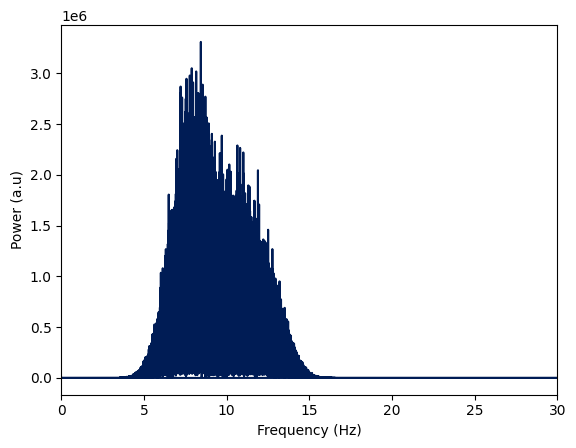

In [9]:
# FFT of filtered LFP

x = LFP_spindle[0]
x = x-np.mean(x)

X = fftpack.fft(x)

freqs = fftpack.fftfreq(len(x), 1/600)

plt.figure()
plt.plot(freqs, np.abs(X),  color = "#001C55")
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (a.u)')
plt.xlim(0,30)

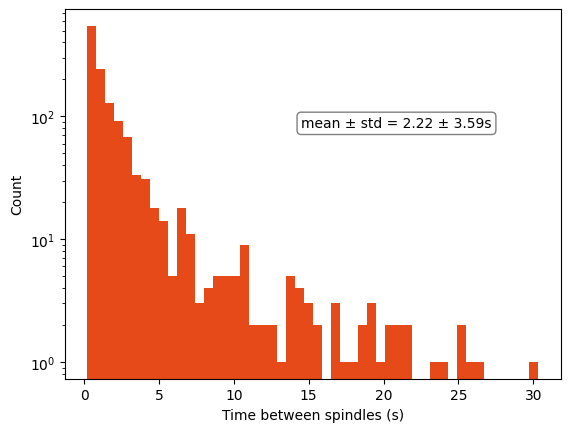

In [18]:
## Interspike interval distribution
# compute time intervals between spindles
intervals = spindleStartEnd[1:, 0] - spindleStartEnd[:-1, 1]
intervals = intervals[intervals <= 40]

# calculate mean and standard deviation
mean = np.mean(intervals)
std = np.std(intervals)

# add text box to plot
textstr = f"mean ± std = {mean:.2f} ± {std:.2f}s"
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
plt.text(14.5, 100, textstr, fontsize=10, verticalalignment='top', bbox=props)

# plot histogram of intervals
plt.hist(intervals, bins=50, color = "#E64A19")
plt.xlabel('Time between spindles (s)')
plt.ylabel('Count')
plt.yscale('log')
plt.show()

Number of spindles before filtering: 140
Number of spindles after filtering: 140


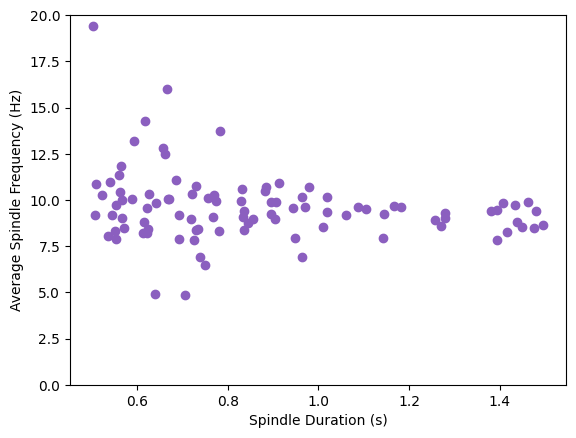

In [21]:
## Plot duration vs frequency
## select spindles with duration between 0.5-3s
## find their instantaneous frequencies

# load spindle start and end times
spindle_times = spindleStartEnd

# define the duration
min_duration = 0.5
max_duration = 3.0

# filter out spindles outside the duration range
filtered_spindles = []
for spindle in spindle_times:
    duration = spindle[1] - spindle[0]
    if min_duration <= duration <= max_duration:
        filtered_spindles.append(spindle)

# convert the filtered spindles to nparray
filtered_spindles = np.array(filtered_spindles)

# print the number of spindles before and after filtering
print(f'Number of spindles before filtering: {len(spindle_times)}')
print(f'Number of spindles after filtering: {len(filtered_spindles)}')

spindleStartEnd = filtered_spindles

# load the LFP signal and extract spindle start and end times
lfp_signal = LFP_spindle[0]
spindle_starts = spindleStartEnd[:,0]
spindle_ends = spindleStartEnd[:,1]

# define the frequency range of interest
freq_range = [6, 14]

# filter the LFP signal in the frequency range of interest
nyquist_freq = 0.5 * len(lfp_signal) / 600  # assuming 1 kHz sampling rate
lfp_filtered = lfp_signal

# Hilbert transform of the filtered LFP signal
hilbert_transform = sig.hilbert(lfp_filtered)

# calculate the instantaneous phase and frequency of the signal
inst_phase = np.unwrap(np.angle(hilbert_transform))
inst_freq = np.diff(inst_phase) / (2 * np.pi) * 600  # convert to Hz

# calculate the duration and average frequency of each spindle
spindle_durations = spindle_ends - spindle_starts
spindle_freqs = []
for i, start in enumerate(spindle_starts):
    end = int(spindle_ends[i])
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        spindle_freqs.append(np.mean(inst_freq[int(start):end]))

# plot spindle duration vs frequency
plt.figure()
plt.scatter(spindle_durations, spindle_freqs, color = '#8B5FBF')
plt.xlabel('Spindle Duration (s)')
plt.ylabel('Average Spindle Frequency (Hz)')
plt.ylim(0, 20)
plt.show()

Text(0, 0.5, 'LFP Amplitude')

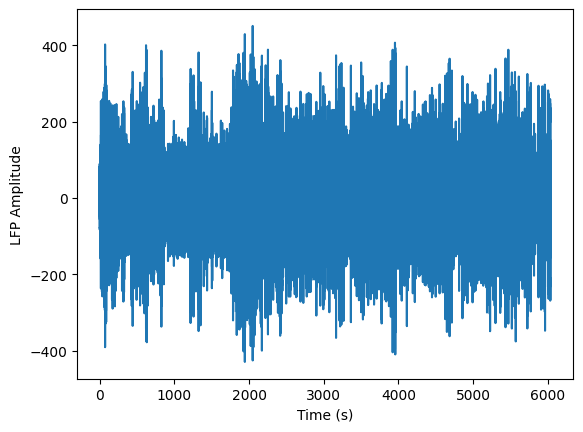

In [22]:
# plot LFP signal
plt.plot(T[0], LFP_spindle[0])
plt.xlabel('Time (s)')
plt.ylabel('LFP Amplitude')

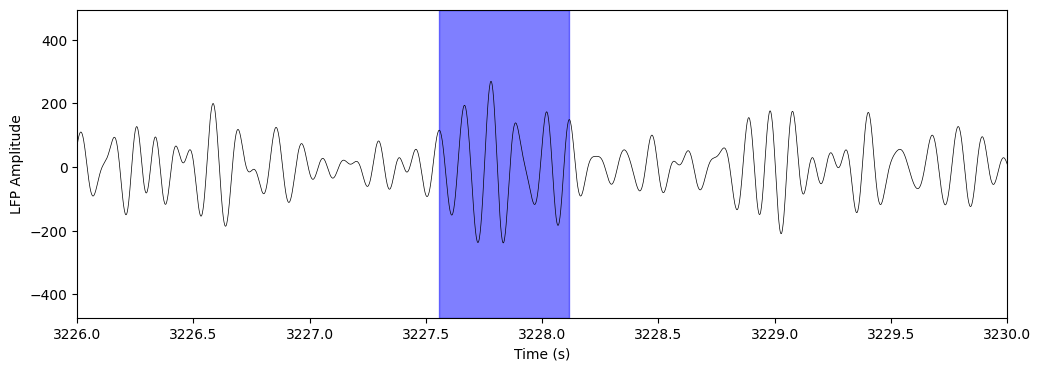

In [23]:
# Here plot separate examples of short spindles(0.5s-0.6s)

lfp_signal = LFP_spindle[0]
spindle_starts = spindleStartEnd[:,0]
spindle_ends = spindleStartEnd[:,1]


# set the sampling rate
fs = 600

# define the time axis
time = np.arange(len(lfp_signal)) / fs

# set spindle duration thresholds
min_duration = 0.5
max_duration = 0.6

# find spindles within the desired duration range
spindle_durations = spindle_ends - spindle_starts
valid_spindle_idxs = np.where((spindle_durations >= min_duration) & (spindle_durations <= max_duration))[0]

# plot the LFP signal
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(time, lfp_signal, 'k', linewidth=0.5)

# plot the selected spindle
for idx in valid_spindle_idxs:
    start_idx = int(spindle_starts[idx] * fs)
    end_idx = int(spindle_ends[idx] * fs)
    duration = spindle_durations[idx]
    color = 'r' if duration == max(spindle_durations) else 'b' # assign red color to longest spindle
    ax.axvspan(time[start_idx], time[end_idx], alpha=0.5, color=color)

# set the x-axis limits and label
ax.set_xlim([3226, 3230]) # this was when min duration was 0.5s
ax.set_xlabel('Time (s)')

# show the mean and standard deviation of spindle durations
mean_duration = np.mean(spindle_durations[valid_spindle_idxs])
std_duration = np.std(spindle_durations[valid_spindle_idxs])
plt.xlabel('Time (s)')
plt.ylabel('LFP Amplitude')
plt.show()

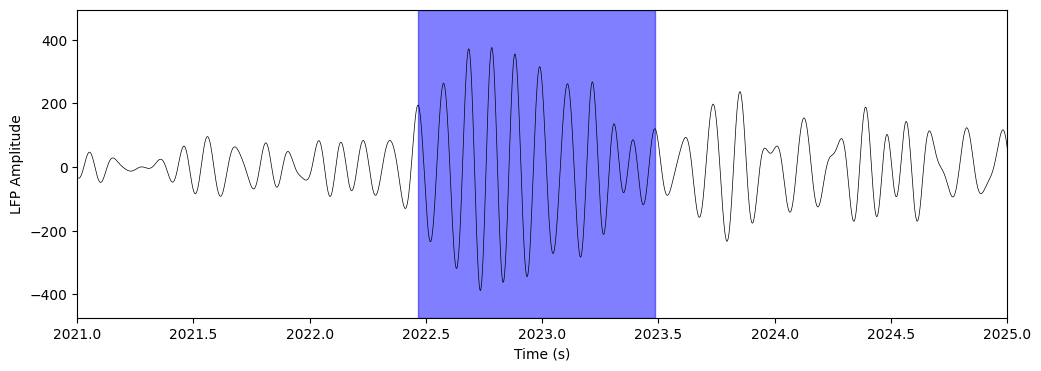

In [25]:
# Here plot separate examples of long spindles (1.0s-1.1s)

lfp_signal = LFP_spindle[0]
spindle_starts = spindleStartEnd[:,0]
spindle_ends = spindleStartEnd[:,1]


# set the sampling rate
fs = 600

# define the time axis
time = np.arange(len(lfp_signal)) / fs

# set spindle duration thresholds
min_duration = 1.0
max_duration = 1.1

# find spindles within the desired duration range
spindle_durations = spindle_ends - spindle_starts
valid_spindle_idxs = np.where((spindle_durations >= min_duration) & (spindle_durations <= max_duration))[0]

# plot the LFP signal
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(time, lfp_signal, 'k', linewidth=0.5)

# plot the selected spindle
for idx in valid_spindle_idxs:
    start_idx = int(spindle_starts[idx] * fs)
    end_idx = int(spindle_ends[idx] * fs)
    duration = spindle_durations[idx]
    color = 'r' if duration == max(spindle_durations) else 'b' # assign red color to longest spindle
    ax.axvspan(time[start_idx], time[end_idx], alpha=0.5, color=color)

# set the x-axis limits and label
ax.set_xlim([2021, 2025]) # this was when min duration was 0.5s
ax.set_xlabel('Time (s)')

# show the mean and standard deviation of spindle durations
mean_duration = np.mean(spindle_durations[valid_spindle_idxs])
std_duration = np.std(spindle_durations[valid_spindle_idxs])
plt.xlabel('Time (s)')
plt.ylabel('LFP Amplitude')
plt.show()